# Run the Self-Organizing Map
Using the SOMOCLU library<br><br>
Training sample: KiDS<br>
Labeling sample: GAMA<br>
____


In [1]:
import os
from glob import glob

from astropy.io import fits
from astropy.table import Table, hstack, vstack

import fitsio

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from matplotlib.patches import Rectangle

from cycler import cycler
plt.rcParams.update({
    'figure.figsize'   : (12, 10),
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   : 5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 7,
    'ytick.major.size' : 7,
    'xtick.major.width': 3,
    'ytick.major.width': 3,
    'xtick.minor.size' : 5,
    'ytick.minor.size' : 5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'lines.linewidth'  : 3,
    'axes.prop_cycle'  : cycler('color', ['red', 'orange', 'teal', 'skyblue']),
})

def Table_to_array(table):
    tuple_data = table.as_array()
    list_data  = [list(values) for values in tuple_data]
    array_data = np.array(list_data, dtype = np.float32)

    return array_data

In [2]:
# #Load in KiDS data
# with fits.open('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24.fits') as cat:
#     KiDS_cat = Table(cat[1].data)
def load_KiDS_data(path):

    cat_section = fitsio.read(path, ext = 1)
    cat_section = Table(cat_section)
    
    redshift_cut = cat_section['redshift'] < 0.4
    size_cut     = cat_section['half_light_radius'] < 5

    cat_section_cut = cat_section[redshift_cut & size_cut]

    colnames = cat_section.dtype.names
    columns = [key for key in colnames\
               if key.endswith('mag')]
    columns +=[key for key in colnames\
               if key.endswith('col')]
    columns +=['half_light_radius']

    cat_section_selected = cat_section_cut[columns]
    # surface_brightness_column = cat_section_cut['r_mag'] + 2.5*np.log10(2 * np.pi * cat_section_cut['half_light_radius'] ** 2)

    # cat_section_selected.add_column(surface_brightness_column,
    #                                 name = 'surf_bright')

    return cat_section_selected.as_array()

In [3]:
#Load in KiDS data
training_data_sec1  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec1.fits')
training_data_sec2  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec2.fits')
training_data_sec3  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec3.fits')
training_data_sec4  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec4.fits')
training_data_sec5  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec5.fits')
training_data_sec6  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec6.fits')
training_data_sec7  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec7.fits')
training_data_sec8  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec8.fits')
training_data_sec9  = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec9.fits')
training_data_sec10 = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec10.fits')
training_data_sec11 = load_KiDS_data('/data2/lsajkov/mpdg/data_products/KiDS/SOM/KiDS_SOM_panchrom_31Jul24/KiDS_SOM_panchrom_31Jul24_sec11.fits')

In [4]:
training_data = np.concatenate([training_data_sec1, 
                                training_data_sec2, 
                                training_data_sec3, 
                                training_data_sec4, 
                                training_data_sec5, 
                                training_data_sec6, 
                                training_data_sec7, 
                                training_data_sec8, 
                                training_data_sec9, 
                                training_data_sec10,
                                training_data_sec11], axis = 0)

training_data_names = training_data.dtype.names
training_data = training_data.view((training_data.dtype[0], len(training_data.dtype.names)))

In [5]:
#Load in GAMA data
# with fits.open('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_panchromatic_catalog_30Jul24.fits') as cat:
#     GAMA_cat = Table(cat[1].data)
with fits.open('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_KiDSphotom_31Jul24.fits') as cat:
    GAMA_cat = Table(cat[1].data)

In [6]:
#Load in COSMOS data
with fits.open('/data2/lsajkov/mpdg/data_products/COSMOS/COSMOS_SOM_panchromatic_catalog_06Aug24.fits') as cat:
    COSMOS_cat = Table(cat[1].data)

In [ ]:
# #Select the needed training data
# # KiDS_mag_cut = KiDS_cat['r_mag'] < 19.5
# KiDS_redshift_cut = KiDS_cat['redshift'] < 0.4
# KiDS_size_cut = KiDS_cat['half_light_radius'] < 5

# training_cat = KiDS_cat[KiDS_redshift_cut & KiDS_size_cut] #& KiDS_mag_cut & KiDS_size_cut]

# # training_data_columns = ['r_mag',
# #                         *[key for key in training_cat.colnames if key.endswith('col')],
# #                          'redshift']

# training_data_columns = [key for key in training_cat.colnames if key.endswith('mag')]
# training_data_columns +=[key for key in training_cat.colnames if key.endswith('col')]
# # training_data_columns = [key for key in training_cat.colnames if key.endswith('col')]
# # training_data_columns.append('half_light_radius')

# training_data = training_cat[training_data_columns]
# training_data.add_column(training_cat['r_mag'] + 2.5 * np.log10(2 * np.pi * training_cat['half_light_radius'] ** 2), name = 'surf_bright')

# training_data_names = training_data_columns
# training_data_names.append('surf_bright')

# training_data = Table_to_array(training_data)

In [7]:
#Select the needed labeling data

GAMA_mag_cut = GAMA_cat['r_mag_1'] < 30
GAMA_redshift_cut = GAMA_cat['redshift'] < 0.4
# GAMA_mstar_cut = GAMA_cat['mstar'] < 10**9.5
GAMA_size_cut = GAMA_cat['half_light_radius_1'] < 5

labels_cat = GAMA_cat[GAMA_redshift_cut & GAMA_mag_cut & GAMA_size_cut]# & GAMA_mstar_cut]

# labeling_data_columns = ['r_mag',
#                         *[key for key in labels_cat.colnames if key.endswith('col')],
#                          'redshift']
labeling_data_columns = [key for key in labels_cat.colnames if (key.endswith('mag') or key.endswith('mag_1'))]
labeling_data_columns +=[key for key in labels_cat.colnames if (key.endswith('col_1') or (key.endswith('col')))]
# labeling_data_columns = [key for key in labels_cat.colnames if (key.endswith('col_1') or (key.endswith('col')))]
# labeling_data_columns.append('half_light_radius_1')

labeling_data_inputs = labels_cat[labeling_data_columns]
labeling_data_inputs.add_column(labels_cat['r_mag_1'] + 2.5 * np.log10(2 * np.pi * labels_cat['half_light_radius_1'] ** 2), name = 'surf_bright')

labeling_data_inputs = Table_to_array(labeling_data_inputs)

labeling_data_outputs = labels_cat['redshift', 'mstar']

labeling_data_outputs = Table_to_array(labeling_data_outputs)

labeling_parameter_names = ['redshift','mstar']


In [8]:
#Select the needed labeling data

COSMOS_redshift_cut = COSMOS_cat['redshift'] < 0.4
# GAMA_mstar_cut = GAMA_cat['mstar'] < 10**9.5
# COSMOS_size_cut = GAMA_cat['half_light_radius_1'] < 5

COSMOS_labels_cat = COSMOS_cat[COSMOS_redshift_cut]# & GAMA_mstar_cut]

# labeling_data_columns = ['r_mag',
#                         *[key for key in labels_cat.colnames if key.endswith('col')],
#                          'redshift']
COSMOS_labeling_data_columns = ['r_mag']
COSMOS_labeling_data_columns +=[key for key in COSMOS_labels_cat.colnames if (key.endswith('mag_2p0_aper'))]
COSMOS_labeling_data_columns +=[key for key in COSMOS_labels_cat.colnames if (key.endswith('col_dered'))]
# labeling_data_columns = [key for key in labels_cat.colnames if (key.endswith('col_1') or (key.endswith('col')))]
# labeling_data_columns.append('half_light_radius_1')

COSMOS_labeling_data_inputs = COSMOS_labels_cat[COSMOS_labeling_data_columns]
COSMOS_labeling_data_inputs.add_column(COSMOS_labels_cat['r_mag'] + 2.5 * np.log10(2 * np.pi * (COSMOS_labels_cat['half_light_radius'] * 0.15) ** 2), name = 'surf_bright')

COSMOS_NaN_mask = np.full(len(COSMOS_labeling_data_inputs), 1, dtype = bool)
for column in COSMOS_labeling_data_inputs.colnames:
    COSMOS_NaN_mask = COSMOS_NaN_mask & ~np.isnan(COSMOS_labeling_data_inputs[column])

COSMOS_labeling_data_inputs = COSMOS_labeling_data_inputs[COSMOS_NaN_mask]

COSMOS_labeling_data_inputs = Table_to_array(COSMOS_labeling_data_inputs)

COSMOS_labeling_data_outputs = COSMOS_labels_cat['redshift', 'mstar']
COSMOS_labeling_data_outputs = COSMOS_labeling_data_outputs[COSMOS_NaN_mask]

COSMOS_labeling_data_outputs = Table_to_array(COSMOS_labeling_data_outputs)

COSMOS_labeling_parameter_names = ['redshift','mstar']


In [9]:
print(np.shape(labeling_data_inputs))
print(np.shape(COSMOS_labeling_data_inputs))
print(np.shape(np.row_stack([labeling_data_inputs, COSMOS_labeling_data_inputs])))

(38712, 47)
(29796, 47)
(68508, 47)


In [10]:
labeling_data_inputs = np.row_stack([labeling_data_inputs,
                               COSMOS_labeling_data_inputs])

labeling_data_outputs = np.row_stack([labeling_data_outputs,
                                COSMOS_labeling_data_outputs])

In [11]:
print(f'Len of training data:\t\t{len(training_data)}')
print(f'Dimension =||=:\t\t\t{np.shape(training_data)[-1]}')
print(f'Len of labeling data inputs:\t{len(labeling_data_inputs)}')
print(f'Dimension =||=:\t\t\t{np.shape(labeling_data_inputs)[-1]}')
print(f'Len of labeling data outputs:\t{len(labeling_data_outputs)}')
print(f'Dimension =||=:\t\t\t{np.shape(labeling_data_outputs)[-1]}')

Len of training data:		2655253
Dimension =||=:			47
Len of labeling data inputs:	68508
Dimension =||=:			47
Len of labeling data outputs:	68508
Dimension =||=:			2


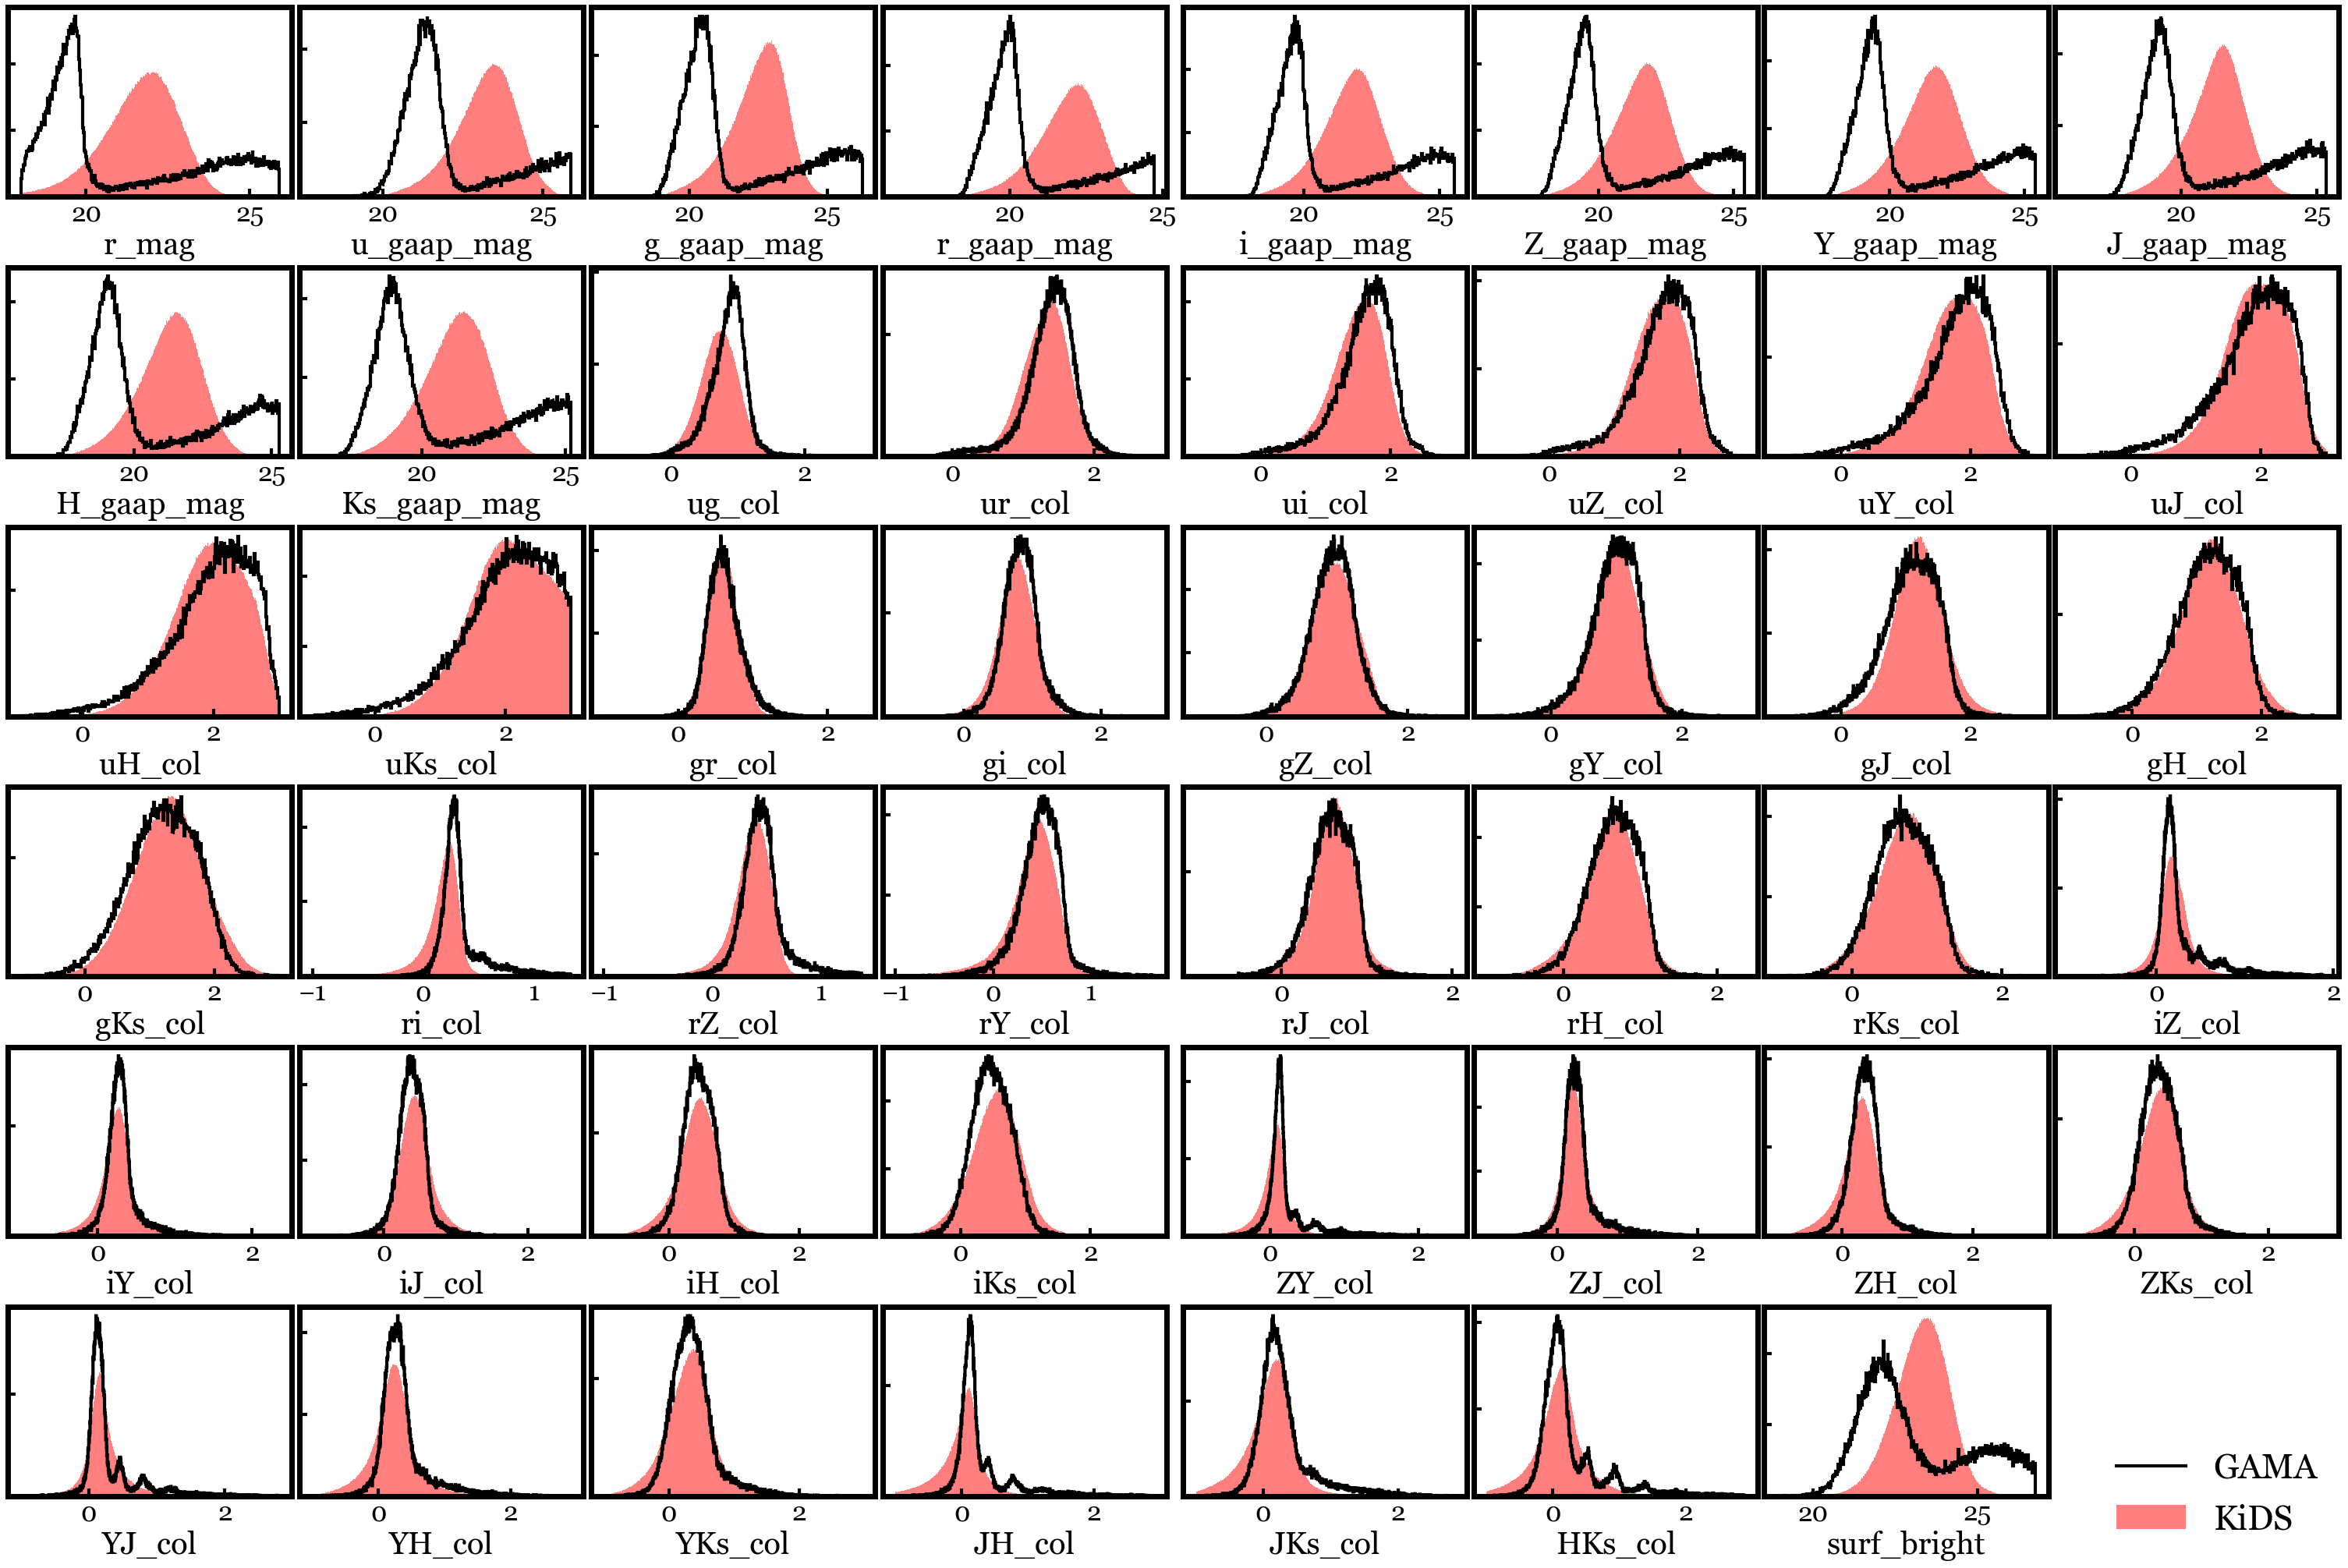

In [81]:
fig = plt.figure(figsize = (30, 20), constrained_layout = True)

for i in range(6):
    for j in range(8):

        ax = fig.add_subplot(6, 8, i*8 + j + 1)

        try:
            # bins = ax.hist(training_data[training_data_names[i*8 + j]], density = True, bins = 'auto', color = ('red', 0.5))[1]
            bins = ax.hist(training_data[:, i*8 + j], density = True, bins = 'auto', color = ('red', 0.5))[1]
            # bins = 'auto'
            ax.hist(labeling_data_inputs[:, i*8 + j], density = True, bins = bins, histtype = 'step', color = 'black', linewidth = 3)
            # if i*8+j+1 != 37: ax.set_xlim(-1, 3)
            ax.set_xlabel(training_data_names[i*8 + j])
            ax.set_yticklabels([])
        except:
            # continue
            ax.axis('off')

GAMA_mappable = plt.plot([], [], color = 'black', linewidth = 3, label = 'GAMA')
KiDS_mappable = plt.hist([], color = ('red', 0.5), label = 'KiDS')

fig.legend(loc = 'lower right', frameon = False, fontsize = 32)

___
Initialize & train the SOM

In [12]:
import somoclu

In [13]:
#set parameters
n_columns      = 48
n_rows         = 48

maptype        = 'toroid'
gridtype       = 'hexagonal'

initialization = 'pca'

neighborhood   = 'gaussian'
std_coeff      = 0.5

verbose        = 2

compactsupport = False

#training parameters
epochs        = 50

radius0       = 0
radiusN       = 1
radiuscooling = 'exponential'

scale0        = 0.25
scaleN        = 0.01
scalecooling  = 'exponential'

In [14]:
SOM = somoclu.Somoclu(n_columns      = n_columns,
                      n_rows         = n_rows,
                      maptype        = maptype,
                      gridtype       = gridtype,
                      initialization = initialization,
                      neighborhood   = neighborhood,
                      std_coeff      = std_coeff,
                      verbose        = verbose,
                      compactsupport = compactsupport,)

In [ ]:
#Select subset of data
data_cut = 'all' #set to 'all' to use all data, otherwise set to an integer

print(f'Initial training data len:\t{len(training_data)}')
if data_cut != 'all':
    randomized_idx = np.arange(0, len(training_data))
    np.random.shuffle(randomized_idx)
    randomized_data_idx = randomized_idx[:data_cut]
    training_data = training_data[randomized_data_idx]
print(f'Subset training data len:\t{len(training_data)}')

In [15]:
# random_data_indices = np.arange(0, len(training_data))
# np.random.shuffle(random_data_indices)

SOM.train(data = training_data,
          epochs = epochs,
          radius0 = radius0, radiusN = radiusN, radiuscooling = radiuscooling,
          scale0 = scale0,   scaleN = scaleN,   scalecooling = scalecooling)

In [ ]:
# SOM.codebook = np.load('/data2/lsajkov/mpdg/saved_soms/02Aug24_all_photom/SOM_codebook.npy', allow_pickle = True)
np.save('/data2/lsajkov/mpdg/saved_soms/07Aug24_surf_bright_COSMOS/SOM_codebook', SOM.codebook, allow_pickle = True)

In [ ]:
#Visualize trained SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows - 1, n_rows),
                       np.linspace(0, n_columns - 1, n_columns))

hexmesh[0][1::2] += 1/2

# fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)
fig = plt.figure(figsize = (80, 60), constrained_layout = True)
transposed_codebook = np.transpose(SOM.codebook, [1, 0, 2])

for i in range(6):
    for j in range(8):

        ax = fig.add_subplot(6, 8, i*8 + j + 1)

        try:
            map = ax.scatter(*hexmesh, c = transposed_codebook[..., i*8 + j], marker = 'h', cmap = 'jet', s = 320)
            # map = ax.scatter(*hexmesh, c = SOM.codebook[..., i*8 + j], marker = 'h', cmap = 'jet', s = 375)
            fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = training_data_names[i*8 + j], shrink = 0.9, pad = 0)
        except: pass
        ax.axis('off')

In [ ]:
training_activation_map = SOM.get_surface_state(data = training_data[0:1000])
training_bmus = SOM.get_bmus(activation_map = training_activation_map)

for step in range(1, int(len(training_data)/1000) + 1):
    i_lo = step * 1000
    i_hi = (step + 1) * 1000

    training_activation_map = SOM.get_surface_state(data = training_data[i_lo:i_hi])
    set_bmus = SOM.get_bmus(activation_map = training_activation_map)
    training_bmus = np.append(training_bmus, set_bmus, axis = 0)

___
Label the SOM & make predictions

In [ ]:
labeling_activation_map = SOM.get_surface_state(data = labeling_data_inputs)
labeling_bmus           = SOM.get_bmus(activation_map = labeling_activation_map)

In [ ]:
def gauss(x, mu, sigma, norm):
    return 1/(norm * sigma) * np.exp(-(x - mu) ** 2/(2 * sigma**2))

In [ ]:
n_params = np.shape(labeling_data_outputs)[1]

labeled_map_values = np.empty((n_rows, n_columns, n_params), dtype = object)
for index, _ in np.ndenumerate(labeled_map_values):
    labeled_map_values[index] = []

for vector_index in range(len(labeling_bmus)):
    for param in range(n_params):
        labeled_map_values[*labeling_bmus[vector_index], param].append(labeling_data_outputs[vector_index, param])

labeled_map = np.empty((n_rows, n_columns, n_params), dtype = float)
for index, values in np.ndenumerate(labeled_map_values):
    if (len(values) > 0) & (index[-1] == 0):
        bins = np.arange(0, 0.41, 0.01)
        vals, _ = np.histogram(labeled_map_values[index], bins = bins)
        try:
            mean, sigma, norm = curve_fit(gauss, bins[:-1], vals,
                                          p0 = [0.1, 0.1, 1], maxfev = 2000)[0]
        except: mean = np.nan
        labeled_map[index] = mean
                                        # weights = 1/np.array(labeled_map_values[index[0], index[1], 0]) ** 2)
    else:
        labeled_map[index] = np.nan

In [ ]:
n_params = np.shape(labeling_data_outputs)[1]

labeled_map_values = np.empty((n_rows, n_columns, n_params), dtype = object)
for index, _ in np.ndenumerate(labeled_map_values):
    labeled_map_values[index] = []

for vector_index in range(len(labeling_bmus)):
    for param in range(n_params):
        labeled_map_values[*labeling_bmus[vector_index], param].append(labeling_data_outputs[vector_index, param])

labeled_map = np.empty((n_rows, n_columns, n_params), dtype = float)
for index, values in np.ndenumerate(labeled_map_values):
    if (len(values) > 0):
        labeled_map[index] = np.median(labeled_map_values[index])
    else: labeled_map[index] = np.nan

In [ ]:
bins = np.arange(0, 0.41, 0.01)
vals, _ = np.histogram(labeled_map_values[0, 0, 0], bins = bins)

fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.stairs(vals, bins, color = 'black')

def gauss(x, mu, sigma, norm):
    return 1/(norm * sigma) * np.exp(-(x - mu) ** 2/(2 * sigma**2))

mean, sigma, norm = curve_fit(gauss, bins[:-1], vals)[0]

ax.plot(bins, gauss(bins, mean, sigma, norm))

In [ ]:
#make mstar log
labeled_map[..., 1] = np.log10(labeled_map[..., 1])

In [ ]:
#Visualize labeled SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                      np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2
# hexmesh = np.transpose(hexmesh, axes = [0, 2, 1])

fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(n_params):
    ax = fig.add_subplot(1, 5, i + 1)

    if i == 0:
        vmin = 0; vmax = 0.4
    if i == 1:
        vmin = 7; vmax = 11
    map = ax.scatter(*hexmesh, c = labeled_map[..., i], marker = 'h', cmap = 'jet', s = 60,
                     vmin = vmin, vmax = vmax)
    ax.axis('off')
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = ['redshift', 'log_mstar'][i], shrink = 0.9)

In [ ]:
occupancy_map = np.empty((n_rows, n_columns), dtype = float)
for index, values in np.ndenumerate(labeled_map_values[..., 0]):
    if len(values) > 0:
        occupancy_map[index] = len(values)
    else: occupancy_map[index] = np.nan

In [ ]:
fig = plt.figure(figsize = (7.5, 9), constrained_layout = True)
ax = fig.add_subplot()
ax.axis('off')

map = ax.scatter(*hexmesh, c = np.log10(occupancy_map), marker = 'h', cmap = 'jet', s = 180)
fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = f'log10(galaxies/cell)\nMean occupancy:{np.nanmean(occupancy_map):.1f}', shrink = 0.9)

In [ ]:
predicted_values_training = np.empty((len(training_data), n_params))
predicted_values_labeling = np.empty((len(labeling_data_inputs), n_params))

for i, bmu in enumerate(training_bmus):
    predicted_values_training[i] = labeled_map[*bmu]

for i, bmu in enumerate(labeling_bmus):
    predicted_values_labeling[i] = labeled_map[*bmu]

In [ ]:
fig = plt.figure(figsize = (24, 10))

ax_l = fig.add_subplot(1, 2, 1)

bins = ax_l.hist(labeling_data_outputs[:, 0], bins = 50, density = True,
                 color = 'green', alpha = 0.25, label = 'GAMA true')[1]

ax_l.hist(predicted_values_labeling[:, 0], bins = bins, density = True,
          histtype = 'step', color = 'black', label = 'GAMA Predicted')

ax_l.set_xlabel('Redshift')
ax_l.set_ylabel('$dN/dz$')
ax_l.legend(frameon = False)

ax_r = fig.add_subplot(1, 2, 2)

bins = ax_r.hist(np.log10(labeling_data_outputs[:, 1]), bins = 50, density = True,
                 color = 'green', alpha = 0.25, label = 'GAMA true')[1]

ax_r.hist(predicted_values_labeling[:, 1], bins = bins, density = True,
          histtype = 'step', color = 'black', label = 'GAMA Predicted')
ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
ax_r.set_ylabel('$dN/dM_*$')
ax_r.legend(frameon = False)

In [ ]:
fig = plt.figure(figsize = (24, 16))

ax_l = fig.add_subplot(1, 2, 1)

hb_l = ax_l.hexbin(labeling_data_outputs[:, 0],
                   predicted_values_labeling[:, 0],
                   mincnt = 1, cmap = 'jet',
                   vmin = 1, vmax = 150)

ax_l.axline([0.2, 0.2], slope = 1, color = 'red')
ax_l.set_xlim(-0.01, 0.405)
ax_l.set_ylim(-0.01, 0.405)
ax_l.set_xticks(np.arange(0, 0.45, 0.05))

ax_l.set_xlabel('GAMA $z$\nTrue')
ax_l.set_ylabel('Predicted\nSOM $z$')

z_MAD = np.mean(np.abs(labeling_data_outputs[:, 0] - predicted_values_labeling[:, 0]))
z_RMSE = np.sqrt(np.mean(labeling_data_outputs[:, 0]**2 - predicted_values_labeling[:, 0] ** 2))

ax_l.text(0.65, 0.05, f'MAD: {z_MAD:.3f} dex\nRMSE: {z_RMSE:.3f} dex',
          transform = ax_l.transAxes)


ax_r = fig.add_subplot(1, 2, 2)


hb_r = ax_r.hexbin(np.log10(labeling_data_outputs[:, 1]),
                   predicted_values_labeling[:, 1],
                   mincnt = 1, cmap = 'jet',
                   vmin = 1, vmax = 150)

ax_r.axline([10, 10], slope = 1, color = 'red')
ax_r.set_xlim(7, 11.2)
ax_r.set_ylim(7, 11.2)
ax_r.set_xticks(np.arange(7, 11.5, 0.5))

ax_r.set_xlabel('GAMA $\log_{10} (M_*/M_{\odot})$\nTrue')
ax_r.set_ylabel('Predicted\nSOM $\log_{10} (M_*/M_{\odot})$')

Mstar_MAD = np.nanmean(np.abs(np.log10(labeling_data_outputs[:, 1]) - predicted_values_labeling[:, 1]))
Mstar_RMSE = np.sqrt(np.mean(np.log10(labeling_data_outputs[:, 1]) - predicted_values_labeling[:, 1]) ** 2)

ax_r.text(0.65, 0.05, f'MAD: {Mstar_MAD:.3f} dex\nRMSE: {Mstar_RMSE:.3f} dex',
          transform = ax_r.transAxes)

fig.subplots_adjust(wspace = 0.25)

fig.colorbar(mappable = hb_l, location = 'bottom', ax = [ax_l, ax_r], shrink = 0.5)

In [ ]:
# np.save(f'/data2/lsajkov/mpdg/saved_soms/30Jul24_mag_cut/r_19p5/codebook', SOM.codebook, allow_pickle = True)
np.save(f'/data2/lsajkov/mpdg/saved_soms/02Aug24_surf_bright/labeled_map_values', labeled_map_values, allow_pickle = True)
np.save(f'/data2/lsajkov/mpdg/saved_soms/02Aug24_surf_bright/labeled_map', labeled_map, allow_pickle = True)
np.save(f'/data2/lsajkov/mpdg/saved_soms/02Aug24_surf_bright/data_bmus', SOM.bmus, allow_pickle = True)
np.save(f'/data2/lsajkov/mpdg/saved_soms/02Aug24_surf_bright/labeling_bmus', labeling_bmus, allow_pickle = True)

In [ ]:
bootstrapped_z = []
bootstrapped_mstar = []

n_params = np.shape(labeling_data_outputs)[1]

for _ in range(25):
    labeled_map_values = np.empty((n_rows, n_columns, n_params), dtype = object)
    for index, _ in np.ndenumerate(labeled_map_values):
        labeled_map_values[index] = []

    for vector_index in range(len(labeling_bmus)):
        for param in range(n_params):
            labeled_map_values[*labeling_bmus[vector_index], param].append(labeling_data_outputs[vector_index, param])

    labeled_map = np.empty((n_rows, n_columns, n_params), dtype = float)
    for index, values in np.ndenumerate(labeled_map_values):
        if len(values) > 0:
            labeled_map[index] = np.random.choice(values)

    predicted_values_training = np.empty((len(training_data), n_params))
    predicted_values_labeling = np.empty((len(labeling_data_inputs), n_params))

    # for i, bmu in enumerate(training_bmus):
    #     predicted_values_training[i] = labeled_map[*bmu]

    for i, bmu in enumerate(labeling_bmus):
        predicted_values_labeling[i] = labeled_map[*bmu]

    bootstrapped_z.append(predicted_values_labeling[:, 0])
    bootstrapped_mstar.append(predicted_values_labeling[:, 1])

In [ ]:
fig = plt.figure(figsize = (24, 10))

ax_l = fig.add_subplot(1, 2, 1)
ax_r = fig.add_subplot(1, 2, 2)

bins_l = ax_l.hist(labeling_data_outputs[:, 0], bins = 50, density = True, histtype = 'stepfilled',
                 color = ('green', 0.25), label = 'GAMA true')[1]

bins_r = ax_r.hist(np.log10(labeling_data_outputs[:, 1]), bins = 50, density = True, histtype = 'stepfilled',
                 color = ('green', 0.25), label = 'GAMA true')[1]

jet = mpl.colormaps['jet']

all_vals_l = []
all_vals_r = []

for i in range(25):
    vals_l, _ = np.histogram(bootstrapped_z[i], bins = bins_l, density = True)

    all_vals_l.append(vals_l)

    # ax_l.plot((bins_l[:-1] + bins_l[1:])/2, vals_l, color = jet(i/24), linewidth = 0.75, alpha = 0.5)

    # ax_l.hist(bootstrapped_z[i], bins = bins_l, density = True,
    #         histtype = 'step', color = jet(i/24), label = 'GAMA Predicted')

    vals_r, _ = np.histogram(np.log10(bootstrapped_mstar[i]), bins = bins_r, density = True)

    all_vals_r.append(vals_r)

    # ax_r.plot((bins_r[:-1] + bins_r[1:])/2, vals_r, color = jet(i/24), linewidth = 0.75, alpha = 0.5)
    # ax_r.hist(np.log10(bootstrapped_mstar[i]), bins = bins_r, density = True,
    #         histtype = 'step', color = jet(i/24), label = 'GAMA Predicted')

ax_l.plot((bins_l[:-1] + bins_l[1:])/2, np.mean(all_vals_l, axis = 0), color = 'black', linewidth = 3, label = 'GAMA bootstrapped')
ax_r.plot((bins_r[:-1] + bins_r[1:])/2, np.mean(all_vals_r, axis = 0), color = 'black', linewidth = 3, label = 'GAMA bootstrapped')

ax_l.set_xlabel('Redshift')
ax_l.set_ylabel('$dN/dz$')
ax_l.legend(frameon = False)
    
ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
ax_r.set_ylabel('$dN/dM_*$')
ax_r.legend(frameon = False)

In [ ]:
labeled_training_cat = training_cat.copy()
labeled_training_cat.add_columns([predicted_values_training[:, 0], predicted_values_training[:, 1]],
                                 names = ['redshift_pred', 'mstar_pred'])

labeled_training_cat.write('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_SOM_surf_bright_02Aug24.fits',
                           overwrite = False)

In [ ]:
n_params = np.shape(labeling_data_outputs)[1]

labeled_map_values = np.empty((n_rows, n_columns, n_params), dtype = object)
for index, _ in np.ndenumerate(labeled_map_values):
    labeled_map_values[index] = []

for vector_index in range(len(labeling_bmus)):
    for param in range(n_params):
        labeled_map_values[*labeling_bmus[vector_index], param].append(labeling_data_outputs[vector_index, param])

labeled_map = np.empty((n_rows, n_columns, n_params), dtype = float)
for index, values in np.ndenumerate(labeled_map_values):
    labeled_map[index] = np.mean(values)

In [ ]:
#Visualize trained SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows - 1, n_rows),
                       np.linspace(0, n_columns - 1, n_columns))

hexmesh[0][1::2] += 1/2

# fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)
fig = plt.figure(figsize = (10, 10), constrained_layout = True)
ax = fig.add_subplot()

map = ax.scatter(*hexmesh, c = SOM.codebook[..., 0], marker = 'h', edgecolor = 'white', cmap = 'jet', s = 375)

highlight = SOM.bmus[0]
highlight = np.array(highlight)

ax.scatter(*(highlight + [(highlight[1]%2)/2,  0]), marker = 'h', color = 'none', edgecolor = 'black', s = 320)

highlight = SOM.bmus[0][::-1]
highlight = np.array(highlight)

ax.scatter(*(highlight + [(highlight[1]%2)/2,  0]), marker = 'h', color = 'none', edgecolor = 'black', s = 320)
ax.axline([0, 0], [40.5, 40], color = 'black')

In [ ]:
#Visualize trained SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                       np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

# fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)
fig = plt.figure(figsize = (80, 60), constrained_layout = True)

for i in range(5):
    for j in range(8):

        ax = fig.add_subplot(5, 8, i*8 + j + 1)

        try:
            map = ax.scatter(*hexmesh, c = SOM.codebook[..., i*8 + j], marker = 'h', cmap = 'jet', s = 375)
            fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = training_data_names[i*8 + j], shrink = 0.9, pad = 0)
        except: pass
        ax.axis('off')

In [ ]:
fig = plt.figure(figsize = (15, 10))
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)

    cell = [np.random.randint(0, 40), np.random.randint(0, 40)]
    color = np.random.randint(0, 36)

    ax.hist(training_data[np.all(training_bmus == cell[::-1], axis = 1), color], density = True,
            bins = np.arange(-1, 2, 0.01), zorder = 99)
    ax.axvline(SOM.codebook[*cell[::-1], color], color = 'black')
    ax.axvline(SOM.codebook[*cell, color], color = 'red')
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(hspace = 0, wspace = 0)